<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project2_transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Tracer transport

A critical aspect of understanding climate and environmental systems is describing the movement of substances. This could include pollution or water vapor in the atmosphere, salt in an estuary, or chemicals in a river. We often model the transport of these substances using an advection/diffusion equation for the concentration of the substance. In this context, we sometimes refer to the concentration field as a `tracer' since it helps us track the movement of individual molecules. We can also use this framework to describe the transport of heat, although in this case the tracer field (temperature or heat content) tracks the movement of thermal energy.

In this project we will use Dedalus to solve advection diffusion equations to describe the vertical distribution of heat in the ocean and the concentration of pollution in a river.

Student tasks are in [Section 1.4](#section1pt4), [Section 1.6](#section1pt6), and [Section 2.3](#section2pt3)

## Setup
If you are using Google colab, run the script below to install Dedalus

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3
  libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 41 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://arch

## 1. Thermal structure in the ocean

Most of the ocean has a stable thermal stratification with warm water at the surface and cold water in the abyss (exceptions occur in salt-stratified waters like the Arctic Ocean). Since the ocean is a massive thermal reservoir, understanding the distribution of this heat is important to quantifying the ocean's role in a changing climate. The structure of the temperature field can also inform us about the circulation in the ocean interior.


### 1.1 Measured temperature profile

The code below plots a sample temperature profile obtained off the coast of California. The data was obtained by digitizing Figure 3 in Munk, 1966.

Text(0, 0.5, 'Depth (m)')

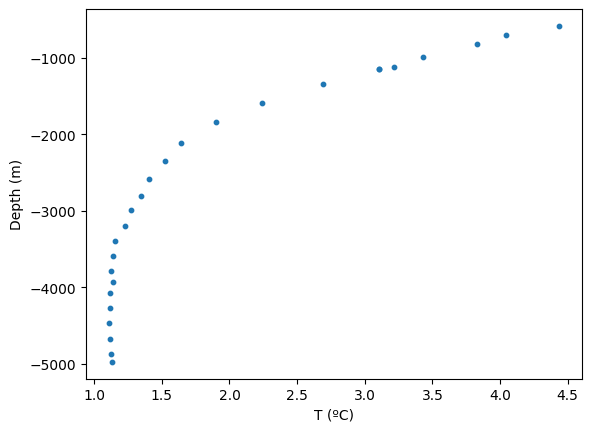

In [2]:
import matplotlib.pyplot as plt

# Temperature measurements extracted from Figure 3 in Munk, 1966
CTD_T = [1.1296296296296295, 1.122004357298475, 1.1143790849673203, 1.1067538126361656, 1.1143790849673203, 1.1143790849673203, 1.1372549019607843, 1.122004357298475, 1.1372549019607843, 1.1525054466230937, 1.2287581699346406, 1.2745098039215685, 1.343137254901961, 1.4041394335511983, 1.526143790849673, 1.6405228758169934, 1.8997821350762527, 2.242919389978214, 2.69281045751634, 3.104575163398693, 3.104575163398693, 3.218954248366013, 3.4324618736383443, 3.8289760348583877, 4.042483660130719, 4.438997821350762]
CTD_z = [-4976.958525345623, -4869.431643625192, -4677.419354838709, -4470.046082949309, -4270.353302611367, -4070.6605222734256, -3932.411674347158, -3786.4823348694317, -3586.78955453149, -3394.7772657450078, -3195.084485407066, -2995.3917050691243, -2803.379416282642, -2580.6451612903224, -2350.230414746544, -2112.1351766513058, -1843.3179723502303, -1597.5422427035332, -1344.0860215053763, -1144.3932411674346, -1144.3932411674346, -1121.351766513057, -990.7834101382491, -821.8125960061443, -698.9247311827958, -583.7173579109067]

plt.scatter(CTD_T,CTD_z,s=10)
plt.xlabel('T (ºC)')
plt.ylabel('Depth (m)')


### 1.2 Abyssal recipes

Munk (1966) proposed that the thermal structure of the ocean interior is set by a balance between upwelling and diffusion. In this view, cold waters sink near the poles and spread across the seafloor before slowly rising through the ocean interior. If we assume, as Munk did, that the water upwells uniformly across the globe, the upwelling speed is approximately $10^{-7}$ m/s. This is far too small to directly measure, but it is large enough to have a major impact on the distribution of tracers. Since light can only penetrate through the top ~100m of ocean, we can ignore solar heating, except in that it sets the temperature near the ocean surface.

### 1.3 Steady advection/diffusion equation

Dedalus can solve differential equations in various forms. In addition to time-dependent initial value problems (IVPs), Dedalus can solve linear and nonlinear boundary value problems. The code below uses Dedalus to solve a linear boundary value problem (IVBP) for the steady state advection/diffusion equation.

Here, the top and bottom temperature are set from the measured profile and these are used as boundary conditions. The vertical (upwelling) velocity is set to $10^{-7} m/s$, and the diffusivity is set to $10^{-7}$ $m^2/s$, to approximate the molecular diffusivity of heat in seawater.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2025-11-10 11:07:54,834 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


Text(0, 0.5, 'Depth (m)')

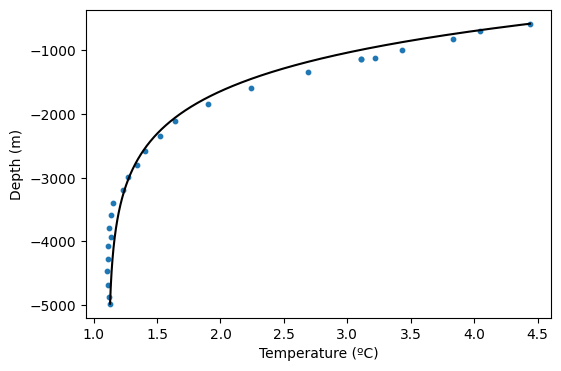

In [3]:
"""
Dedalus script to solve the steady advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the upwelling velocity
w = 1e-7 # m/s
# Set the diffusivity
kappa= 8e-5 # m^2/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - kappa*Tzz = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.4 Student investigation
<a id='section1pt4'></a>
Note that the profile above is not a good fit to the data. This implies that molecular diffusion isn't sufficient to transport heat down from the surface and stop the ocean from filling up with cold, dense water.

Munk (1966) proposed that small-scale turbulence in the ocean interior results in a diffusivity that is orders of magnitude larger than the molecular value. Find a diffusivity that gives a good match with the data and test it in the Dedalus script above. Comment on the ability of this model (steady advection/diffusion) to fit the data.

original= K=1e_7 after iterations found 8e-5 to be the best fit. this is almost 3 orders of magnitude higher than that predicted by the molecular level alone. this suggests that the mollecular level diffusion is insignificant in the process of heat transport in the ocean in comparison to the role of turbulence.
With K=8e-5, the model predicts the behaviour fairly well but it still smooths the behaviour. it fails to represent the near-isothermal behaviour of the very deep ocean and the shoudler of the curve is at a slightly lower depth, resulting in an overestimate of surface temperatures by up to half a degree.

### 1.5 Turning ocean mixing upside down

Decades of research to measure the turbulent diffusivity in the ocean consistently found values much smaller than the one predicted by Munk (1966). Specifically, while larger values of the turbulent diffusivity were found near the bottom of the ocean over rough topographic features, the values in the upper ocean were about 10x smaller than the values predicted by Munk. 50 years after Munk's seminal paper, Ferrari et al. (2016) proposed that a depth-dependent turbulent diffusivity could be balanced by <em>downwelling</em>, with negative vertical velocities in the ocean interior. In this theory, the overturning circulation is upwelling in thin boundary layers along the sloping sides of the ocean basins.

When the diffusivity, $\kappa$, is a function of $z$, the steady advection/diffusion equation can be written

$$ w\frac{dT}{dz} = \frac{d}{dz}\left(\kappa(z) \frac{dT}{dz}\right)$$

The Dedalus script below solves the previous equation and again compares the results with the observed temperature profile. For the depth-dependent diffusivity, $\kappa(z)$, we take

$$ \kappa(z)=\kappa_{bg} + (\kappa_0-\kappa_{bg})e^{-(z+D)/l} $$

using the form from Rogers et al., 2023, where $\kappa_{bg}=1\times 10^{-5} m^2/s$ is the background diffusivity characteristic of the upper water column, $\kappa_0=8.6\times 10^{-4} m^2/s$ characterizes the enhanced mixing near the bottom of the ocean, $D$ is a reference depth where $\kappa=\kappa_0$, and $l=667m$ is an exponential decay scale. In the script below, we start with $w=0$.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


2025-11-10 11:07:56,153 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


Text(0, 0.5, 'Depth (m)')

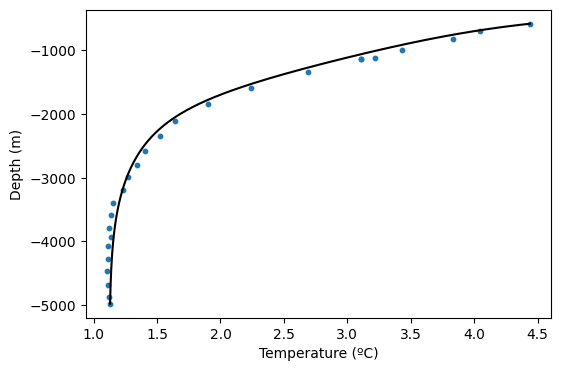

In [4]:
"""
Dedalus script to solve the steady advection/diffusion equation
with a spatially-variable diffusivity
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the vertical velocity
w = 2e-9 # m/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)
kappa = dist.Field(name='kappa', bases=zbasis)
# Set the diffusivity
# Below is the diffusivity profile from Rogers et al., 2023
kappa['g']=0.2*(1e-5 + (8.6e-4-1e-5)*np.exp((-5e3-z)/667)) # m^2/s

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.6 Student investigation
<a id='section1pt6'></a>
Note from the results of the script above that the density profile is reasonable, even though $w=0$. In the box below, comment on the balance in this case and what this implies about the diffusive heat flux.

Next, find a vertical velocity that produces a better agreement with the observations and report it below. Then, try varying the details of the $\kappa(z)$ profile. How sensitive is the optimal $w$ to your choice of $\kappa(z)$? What does this imply about the circulation in the ocean interior if $\kappa(z)$ varies between regions of smooth and rough topography?

(As an aside, note that the requied vertical velocity is much smaller than the one used by Munk (1966). This implies that the dense, cold water that sinks at the poles must rise elsewhere. Ferrari et al. (2016) proposed that this occurs in boundary layers near the seafloor.)

for w=0, the advection-diffusion equation implies that dK/dz=0 ie that the diffusivity is set at the backgrund diffusivity.

If w=0, $$\frac{d}{dz}\left(\kappa(z) \frac{dT}{dz}\right)$$= (expand by product rule)=0 so both terms in derivative must balance

thermal flux= -k dT/dz
k(z)dT/dz must be a constant ie large flux implies small k. iinitally, dt/dz is very large  implies small k, then as dt/dz decreases k will increase. ie temp flux is linked to diffusivity.

best fit w = 1e-8
varying k:
when we mulitplied K by 5, the solution became less accurate. we had to multiply our w by 5 to get a best fit model. similarly, when k was reduced by a factor of 5 the best fit w was 0.2 of that used in the initial condition. ie 2e-9. this implied that w varies linearly with the value of k so w and k are very closely related. physically this means that the downwelling velcoity will vary in parts of the ocean with different diffusivities ie different topographies.



## 2. Transport of pollution in a river

Advection/diffusion equations are a common way to model the material transport in many physical systems. In this section we will model the transport and dilution of a pollutants added to a river.

For simplicity, we will model the river as a rectangular channel, and we will neglect depth variations. Let $x$ be the coordinate along the length of the river, and $y$ be the cross-stream coordinate. We will model the river current as

$$ u(y) = U_0\left(1-\frac{(y-w/2)^2}{(w/2)^2}\right) $$

where $w$ is the width of the river and $U_0$ is the maximum current speed which occurs at the center of the river (the $y$-coordinate will run from 0 to $w$).

Since we want to know how the pollution levels vary in time, we will solve the time-dependent advection/diffusion equation. We will model the addition of pollution by adding a spatially-dependent source term to the right hand side of the equation governing pollutant concentration:

$$ \frac{\partial c}{\partial t} + u(y)\frac{\partial c}{\partial x} = \kappa \nabla^2 c + S(x,y) $$

where $\nabla^2=(\partial_x^2 + \partial_y^2)$ is the Laplacian operator for diffusion in 2D Cartesian coordinates, and $S$ is the source term.

### 2.1 Dedalus script

The script below solves the time-dependent advection/diffusion equation with a source term.

In [5]:
"""
Script to solve the time-dependent advection/diffusion equation
"""


import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s


2025-11-10 11:07:57,268 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s


INFO:__main__:Starting main loop


2025-11-10 11:07:57,276 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-10 11:07:59,000 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-10 11:07:59,159 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-10 11:07:59,239 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-10 11:07:59,285 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-10 11:07:59,343 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-10 11:07:59,464 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-10 11:07:59,541 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-10 11:07:59,611 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-10 11:07:59,727 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-10 11:07:59,800 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-10 11:07:59,884 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-10 11:08:00,018 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-10 11:08:00,068 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-10 11:08:00,138 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-10 11:08:00,230 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-10 11:08:00,297 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-10 11:08:00,360 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-10 11:08:00,451 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-10 11:08:00,538 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-10 11:08:00,621 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-10 11:08:00,691 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-10 11:08:00,745 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-10 11:08:00,833 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-10 11:08:00,885 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-10 11:08:00,935 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-10 11:08:01,026 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-10 11:08:01,086 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-10 11:08:01,164 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-10 11:08:01,226 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-10 11:08:01,265 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-10 11:08:01,302 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-10 11:08:01,338 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-10 11:08:01,375 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-10 11:08:01,415 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-10 11:08:01,456 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-10 11:08:01,511 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-10 11:08:01,579 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-10 11:08:01,623 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-10 11:08:01,673 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-10 11:08:01,729 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-10 11:08:01,791 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-10 11:08:01,838 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-10 11:08:01,912 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-10 11:08:01,984 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-10 11:08:02,026 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-10 11:08:02,099 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-10 11:08:02,208 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-10 11:08:02,285 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-10 11:08:02,326 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-10 11:08:02,372 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-10 11:08:02,413 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-10 11:08:02,463 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-10 11:08:02,517 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-10 11:08:02,564 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-10 11:08:02,612 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-10 11:08:02,658 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-10 11:08:02,707 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-10 11:08:02,755 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-10 11:08:02,809 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-10 11:08:02,859 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-10 11:08:02,943 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-10 11:08:03,011 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-10 11:08:03,077 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-10 11:08:03,141 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-10 11:08:03,187 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-10 11:08:03,251 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-10 11:08:03,306 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-10 11:08:03,366 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-10 11:08:03,415 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-10 11:08:03,458 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-10 11:08:03,516 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-10 11:08:03,564 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-10 11:08:03,613 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-10 11:08:03,678 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-10 11:08:03,732 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-10 11:08:03,802 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-10 11:08:03,870 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-10 11:08:03,939 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-10 11:08:03,948 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-10 11:08:03,957 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.6204 sec


2025-11-10 11:08:03,972 solvers 0/1 INFO :: Setup time (init - iter 0): 0.6204 sec


INFO:solvers:Warmup time (iter 0-10): 1.874 sec


2025-11-10 11:08:03,975 solvers 0/1 INFO :: Warmup time (iter 0-10): 1.874 sec


INFO:solvers:Run time (iter 10-end): 4.793 sec


2025-11-10 11:08:03,981 solvers 0/1 INFO :: Run time (iter 10-end): 4.793 sec


INFO:solvers:CPU time (iter 10-end): 0.001331 cpu-hr


2025-11-10 11:08:03,986 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001331 cpu-hr


INFO:solvers:Speed: 2.742e+06 mode-stages/cpu-sec


2025-11-10 11:08:03,988 solvers 0/1 INFO :: Speed: 2.742e+06 mode-stages/cpu-sec


## 2.2 Visualization

The script below makes a movie of the results from the saved variables. To run this, you need to have ffmpeg installed.  If you don't already have it installed, you can install ffmpeg with the command:

`conda install -c conda-forge ffmpeg`

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-10 11:08:04,655 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp8tjhrltz/temp.m4v


2025-11-10 11:08:04,660 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp8tjhrltz/temp.m4v


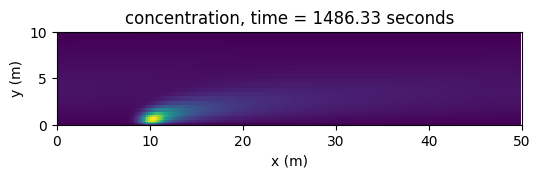

In [6]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)
    plt.ylim(0, w)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

## 2.3 Student investigation
<a id='section2pt3'></a>
### Advective/diffusive timescales
In the boxes below, plot the pollution concentration at a few points as a function of time. Then vary the maximum flow speed and the diffusivity and explore how the pollution levels depend on these parameters. Using dimensional analysis, estimate the time needed for the pollution to reach the opposite side of the river. How far downstream of the source do you expect this to happen (assuming that the domain in the x-direction is infinite).

In [7]:
# ADD YOUR CODE HERE
print(c_save.shape)


(78, 256, 32)


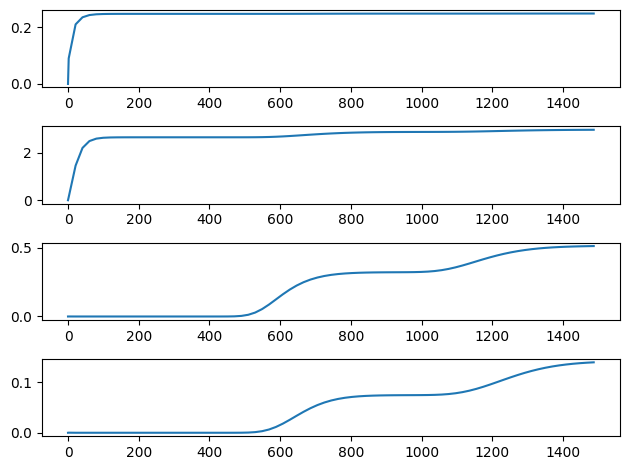

In [8]:
plt.figure()
plt.subplot(4,1,1)
plt.plot(t_save,c_save[:,50,0])

plt.subplot(4,1,2)
plt.plot(t_save,c_save[:,50,8])

plt.subplot(4,1,3)
plt.plot(t_save, c_save[:,50,16])

plt.subplot(4,1,4)
plt.plot(t_save, c_save[:,50,24])

plt.tight_layout()

plt.show()

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2025-11-10 11:08:24,955 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


INFO:__main__:Starting main loop


2025-11-10 11:08:24,960 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=9.765625e-01, dt=9.765625e-01


2025-11-10 11:08:24,998 __main__ 0/1 INFO :: Iteration=1, Time=9.765625e-01, dt=9.765625e-01


INFO:__main__:Iteration=11, Time=1.074219e+01, dt=9.765625e-01


2025-11-10 11:08:25,027 __main__ 0/1 INFO :: Iteration=11, Time=1.074219e+01, dt=9.765625e-01


INFO:__main__:Iteration=21, Time=2.050781e+01, dt=9.765625e-01


2025-11-10 11:08:25,056 __main__ 0/1 INFO :: Iteration=21, Time=2.050781e+01, dt=9.765625e-01


INFO:__main__:Iteration=31, Time=3.027344e+01, dt=9.765625e-01


2025-11-10 11:08:25,086 __main__ 0/1 INFO :: Iteration=31, Time=3.027344e+01, dt=9.765625e-01


INFO:__main__:Iteration=41, Time=4.003906e+01, dt=9.765625e-01


2025-11-10 11:08:25,115 __main__ 0/1 INFO :: Iteration=41, Time=4.003906e+01, dt=9.765625e-01


INFO:__main__:Iteration=51, Time=4.980469e+01, dt=9.765625e-01


2025-11-10 11:08:25,146 __main__ 0/1 INFO :: Iteration=51, Time=4.980469e+01, dt=9.765625e-01


INFO:__main__:Iteration=61, Time=5.957031e+01, dt=9.765625e-01


2025-11-10 11:08:25,177 __main__ 0/1 INFO :: Iteration=61, Time=5.957031e+01, dt=9.765625e-01


INFO:__main__:Iteration=71, Time=6.933594e+01, dt=9.765625e-01


2025-11-10 11:08:25,206 __main__ 0/1 INFO :: Iteration=71, Time=6.933594e+01, dt=9.765625e-01


INFO:__main__:Iteration=81, Time=7.910156e+01, dt=9.765625e-01


2025-11-10 11:08:25,241 __main__ 0/1 INFO :: Iteration=81, Time=7.910156e+01, dt=9.765625e-01


INFO:__main__:Iteration=91, Time=8.886719e+01, dt=9.765625e-01


2025-11-10 11:08:25,270 __main__ 0/1 INFO :: Iteration=91, Time=8.886719e+01, dt=9.765625e-01


INFO:__main__:Iteration=101, Time=9.863281e+01, dt=9.765625e-01


2025-11-10 11:08:25,299 __main__ 0/1 INFO :: Iteration=101, Time=9.863281e+01, dt=9.765625e-01


INFO:__main__:Iteration=111, Time=1.083984e+02, dt=9.765625e-01


2025-11-10 11:08:25,328 __main__ 0/1 INFO :: Iteration=111, Time=1.083984e+02, dt=9.765625e-01


INFO:__main__:Iteration=121, Time=1.181641e+02, dt=9.765625e-01


2025-11-10 11:08:25,357 __main__ 0/1 INFO :: Iteration=121, Time=1.181641e+02, dt=9.765625e-01


INFO:__main__:Iteration=131, Time=1.279297e+02, dt=9.765625e-01


2025-11-10 11:08:25,388 __main__ 0/1 INFO :: Iteration=131, Time=1.279297e+02, dt=9.765625e-01


INFO:__main__:Iteration=141, Time=1.376953e+02, dt=9.765625e-01


2025-11-10 11:08:25,422 __main__ 0/1 INFO :: Iteration=141, Time=1.376953e+02, dt=9.765625e-01


INFO:__main__:Iteration=151, Time=1.474609e+02, dt=9.765625e-01


2025-11-10 11:08:25,450 __main__ 0/1 INFO :: Iteration=151, Time=1.474609e+02, dt=9.765625e-01


INFO:__main__:Iteration=161, Time=1.572266e+02, dt=9.765625e-01


2025-11-10 11:08:25,496 __main__ 0/1 INFO :: Iteration=161, Time=1.572266e+02, dt=9.765625e-01


INFO:__main__:Iteration=171, Time=1.669922e+02, dt=9.765625e-01


2025-11-10 11:08:25,526 __main__ 0/1 INFO :: Iteration=171, Time=1.669922e+02, dt=9.765625e-01


INFO:__main__:Iteration=181, Time=1.767578e+02, dt=9.765625e-01


2025-11-10 11:08:25,553 __main__ 0/1 INFO :: Iteration=181, Time=1.767578e+02, dt=9.765625e-01


INFO:__main__:Iteration=191, Time=1.865234e+02, dt=9.765625e-01


2025-11-10 11:08:25,583 __main__ 0/1 INFO :: Iteration=191, Time=1.865234e+02, dt=9.765625e-01


INFO:__main__:Iteration=201, Time=1.962891e+02, dt=9.765625e-01


2025-11-10 11:08:25,611 __main__ 0/1 INFO :: Iteration=201, Time=1.962891e+02, dt=9.765625e-01


INFO:__main__:Iteration=211, Time=2.060547e+02, dt=9.765625e-01


2025-11-10 11:08:25,640 __main__ 0/1 INFO :: Iteration=211, Time=2.060547e+02, dt=9.765625e-01


INFO:__main__:Iteration=221, Time=2.158203e+02, dt=9.765625e-01


2025-11-10 11:08:25,668 __main__ 0/1 INFO :: Iteration=221, Time=2.158203e+02, dt=9.765625e-01


INFO:__main__:Iteration=231, Time=2.255859e+02, dt=9.765625e-01


2025-11-10 11:08:25,695 __main__ 0/1 INFO :: Iteration=231, Time=2.255859e+02, dt=9.765625e-01


INFO:__main__:Iteration=241, Time=2.353516e+02, dt=9.765625e-01


2025-11-10 11:08:25,724 __main__ 0/1 INFO :: Iteration=241, Time=2.353516e+02, dt=9.765625e-01


INFO:__main__:Iteration=251, Time=2.451172e+02, dt=9.765625e-01


2025-11-10 11:08:25,753 __main__ 0/1 INFO :: Iteration=251, Time=2.451172e+02, dt=9.765625e-01


INFO:__main__:Iteration=261, Time=2.548828e+02, dt=9.765625e-01


2025-11-10 11:08:25,785 __main__ 0/1 INFO :: Iteration=261, Time=2.548828e+02, dt=9.765625e-01


INFO:__main__:Iteration=271, Time=2.646484e+02, dt=9.765625e-01


2025-11-10 11:08:25,816 __main__ 0/1 INFO :: Iteration=271, Time=2.646484e+02, dt=9.765625e-01


INFO:__main__:Iteration=281, Time=2.744141e+02, dt=9.765625e-01


2025-11-10 11:08:25,844 __main__ 0/1 INFO :: Iteration=281, Time=2.744141e+02, dt=9.765625e-01


INFO:__main__:Iteration=291, Time=2.841797e+02, dt=9.765625e-01


2025-11-10 11:08:25,872 __main__ 0/1 INFO :: Iteration=291, Time=2.841797e+02, dt=9.765625e-01


INFO:__main__:Iteration=301, Time=2.939453e+02, dt=9.765625e-01


2025-11-10 11:08:25,906 __main__ 0/1 INFO :: Iteration=301, Time=2.939453e+02, dt=9.765625e-01


INFO:__main__:Iteration=311, Time=3.037109e+02, dt=9.765625e-01


2025-11-10 11:08:25,933 __main__ 0/1 INFO :: Iteration=311, Time=3.037109e+02, dt=9.765625e-01


INFO:__main__:Iteration=321, Time=3.134766e+02, dt=9.765625e-01


2025-11-10 11:08:25,963 __main__ 0/1 INFO :: Iteration=321, Time=3.134766e+02, dt=9.765625e-01


INFO:__main__:Iteration=331, Time=3.232422e+02, dt=9.765625e-01


2025-11-10 11:08:25,992 __main__ 0/1 INFO :: Iteration=331, Time=3.232422e+02, dt=9.765625e-01


INFO:__main__:Iteration=341, Time=3.330078e+02, dt=9.765625e-01


2025-11-10 11:08:26,022 __main__ 0/1 INFO :: Iteration=341, Time=3.330078e+02, dt=9.765625e-01


INFO:__main__:Iteration=351, Time=3.427734e+02, dt=9.765625e-01


2025-11-10 11:08:26,053 __main__ 0/1 INFO :: Iteration=351, Time=3.427734e+02, dt=9.765625e-01


INFO:__main__:Iteration=361, Time=3.525391e+02, dt=9.765625e-01


2025-11-10 11:08:26,083 __main__ 0/1 INFO :: Iteration=361, Time=3.525391e+02, dt=9.765625e-01


INFO:__main__:Iteration=371, Time=3.623047e+02, dt=9.765625e-01


2025-11-10 11:08:26,113 __main__ 0/1 INFO :: Iteration=371, Time=3.623047e+02, dt=9.765625e-01


INFO:__main__:Iteration=381, Time=3.720703e+02, dt=9.765625e-01


2025-11-10 11:08:26,140 __main__ 0/1 INFO :: Iteration=381, Time=3.720703e+02, dt=9.765625e-01


INFO:__main__:Iteration=391, Time=3.818359e+02, dt=9.765625e-01


2025-11-10 11:08:26,170 __main__ 0/1 INFO :: Iteration=391, Time=3.818359e+02, dt=9.765625e-01


INFO:__main__:Iteration=401, Time=3.916016e+02, dt=9.765625e-01


2025-11-10 11:08:26,200 __main__ 0/1 INFO :: Iteration=401, Time=3.916016e+02, dt=9.765625e-01


INFO:__main__:Iteration=411, Time=4.013672e+02, dt=9.765625e-01


2025-11-10 11:08:26,229 __main__ 0/1 INFO :: Iteration=411, Time=4.013672e+02, dt=9.765625e-01


INFO:__main__:Iteration=421, Time=4.111328e+02, dt=9.765625e-01


2025-11-10 11:08:26,257 __main__ 0/1 INFO :: Iteration=421, Time=4.111328e+02, dt=9.765625e-01


INFO:__main__:Iteration=431, Time=4.208984e+02, dt=9.765625e-01


2025-11-10 11:08:26,286 __main__ 0/1 INFO :: Iteration=431, Time=4.208984e+02, dt=9.765625e-01


INFO:__main__:Iteration=441, Time=4.306641e+02, dt=9.765625e-01


2025-11-10 11:08:26,317 __main__ 0/1 INFO :: Iteration=441, Time=4.306641e+02, dt=9.765625e-01


INFO:__main__:Iteration=451, Time=4.404297e+02, dt=9.765625e-01


2025-11-10 11:08:26,346 __main__ 0/1 INFO :: Iteration=451, Time=4.404297e+02, dt=9.765625e-01


INFO:__main__:Iteration=461, Time=4.501953e+02, dt=9.765625e-01


2025-11-10 11:08:26,377 __main__ 0/1 INFO :: Iteration=461, Time=4.501953e+02, dt=9.765625e-01


INFO:__main__:Iteration=471, Time=4.599609e+02, dt=9.765625e-01


2025-11-10 11:08:26,407 __main__ 0/1 INFO :: Iteration=471, Time=4.599609e+02, dt=9.765625e-01


INFO:__main__:Iteration=481, Time=4.697266e+02, dt=9.765625e-01


2025-11-10 11:08:26,441 __main__ 0/1 INFO :: Iteration=481, Time=4.697266e+02, dt=9.765625e-01


INFO:__main__:Iteration=491, Time=4.794922e+02, dt=9.765625e-01


2025-11-10 11:08:26,471 __main__ 0/1 INFO :: Iteration=491, Time=4.794922e+02, dt=9.765625e-01


INFO:__main__:Iteration=501, Time=4.892578e+02, dt=9.765625e-01


2025-11-10 11:08:26,507 __main__ 0/1 INFO :: Iteration=501, Time=4.892578e+02, dt=9.765625e-01


INFO:__main__:Iteration=511, Time=4.990234e+02, dt=9.765625e-01


2025-11-10 11:08:26,546 __main__ 0/1 INFO :: Iteration=511, Time=4.990234e+02, dt=9.765625e-01


INFO:__main__:Iteration=521, Time=5.087891e+02, dt=9.765625e-01


2025-11-10 11:08:26,578 __main__ 0/1 INFO :: Iteration=521, Time=5.087891e+02, dt=9.765625e-01


INFO:__main__:Iteration=531, Time=5.185547e+02, dt=9.765625e-01


2025-11-10 11:08:26,607 __main__ 0/1 INFO :: Iteration=531, Time=5.185547e+02, dt=9.765625e-01


INFO:__main__:Iteration=541, Time=5.283203e+02, dt=9.765625e-01


2025-11-10 11:08:26,637 __main__ 0/1 INFO :: Iteration=541, Time=5.283203e+02, dt=9.765625e-01


INFO:__main__:Iteration=551, Time=5.380859e+02, dt=9.765625e-01


2025-11-10 11:08:26,669 __main__ 0/1 INFO :: Iteration=551, Time=5.380859e+02, dt=9.765625e-01


INFO:__main__:Iteration=561, Time=5.478516e+02, dt=9.765625e-01


2025-11-10 11:08:26,698 __main__ 0/1 INFO :: Iteration=561, Time=5.478516e+02, dt=9.765625e-01


INFO:__main__:Iteration=571, Time=5.576172e+02, dt=9.765625e-01


2025-11-10 11:08:26,729 __main__ 0/1 INFO :: Iteration=571, Time=5.576172e+02, dt=9.765625e-01


INFO:__main__:Iteration=581, Time=5.673828e+02, dt=9.765625e-01


2025-11-10 11:08:26,758 __main__ 0/1 INFO :: Iteration=581, Time=5.673828e+02, dt=9.765625e-01


INFO:__main__:Iteration=591, Time=5.771484e+02, dt=9.765625e-01


2025-11-10 11:08:26,789 __main__ 0/1 INFO :: Iteration=591, Time=5.771484e+02, dt=9.765625e-01


INFO:__main__:Iteration=601, Time=5.869141e+02, dt=9.765625e-01


2025-11-10 11:08:26,824 __main__ 0/1 INFO :: Iteration=601, Time=5.869141e+02, dt=9.765625e-01


INFO:__main__:Iteration=611, Time=5.966797e+02, dt=9.765625e-01


2025-11-10 11:08:26,853 __main__ 0/1 INFO :: Iteration=611, Time=5.966797e+02, dt=9.765625e-01


INFO:__main__:Iteration=621, Time=6.064453e+02, dt=9.765625e-01


2025-11-10 11:08:26,883 __main__ 0/1 INFO :: Iteration=621, Time=6.064453e+02, dt=9.765625e-01


INFO:__main__:Iteration=631, Time=6.162109e+02, dt=9.765625e-01


2025-11-10 11:08:26,912 __main__ 0/1 INFO :: Iteration=631, Time=6.162109e+02, dt=9.765625e-01


INFO:__main__:Iteration=641, Time=6.259766e+02, dt=9.765625e-01


2025-11-10 11:08:26,940 __main__ 0/1 INFO :: Iteration=641, Time=6.259766e+02, dt=9.765625e-01


INFO:__main__:Iteration=651, Time=6.357422e+02, dt=9.765625e-01


2025-11-10 11:08:26,970 __main__ 0/1 INFO :: Iteration=651, Time=6.357422e+02, dt=9.765625e-01


INFO:__main__:Iteration=661, Time=6.455078e+02, dt=9.765625e-01


2025-11-10 11:08:26,998 __main__ 0/1 INFO :: Iteration=661, Time=6.455078e+02, dt=9.765625e-01


INFO:__main__:Iteration=671, Time=6.552734e+02, dt=9.765625e-01


2025-11-10 11:08:27,029 __main__ 0/1 INFO :: Iteration=671, Time=6.552734e+02, dt=9.765625e-01


INFO:__main__:Iteration=681, Time=6.650391e+02, dt=9.765625e-01


2025-11-10 11:08:27,058 __main__ 0/1 INFO :: Iteration=681, Time=6.650391e+02, dt=9.765625e-01


INFO:__main__:Iteration=691, Time=6.748047e+02, dt=9.765625e-01


2025-11-10 11:08:27,087 __main__ 0/1 INFO :: Iteration=691, Time=6.748047e+02, dt=9.765625e-01


INFO:__main__:Iteration=701, Time=6.845703e+02, dt=9.765625e-01


2025-11-10 11:08:27,121 __main__ 0/1 INFO :: Iteration=701, Time=6.845703e+02, dt=9.765625e-01


INFO:__main__:Iteration=711, Time=6.943359e+02, dt=9.765625e-01


2025-11-10 11:08:27,154 __main__ 0/1 INFO :: Iteration=711, Time=6.943359e+02, dt=9.765625e-01


INFO:__main__:Iteration=721, Time=7.041016e+02, dt=9.765625e-01


2025-11-10 11:08:27,182 __main__ 0/1 INFO :: Iteration=721, Time=7.041016e+02, dt=9.765625e-01


INFO:__main__:Iteration=731, Time=7.138672e+02, dt=9.765625e-01


2025-11-10 11:08:27,212 __main__ 0/1 INFO :: Iteration=731, Time=7.138672e+02, dt=9.765625e-01


INFO:__main__:Iteration=741, Time=7.236328e+02, dt=9.765625e-01


2025-11-10 11:08:27,241 __main__ 0/1 INFO :: Iteration=741, Time=7.236328e+02, dt=9.765625e-01


INFO:__main__:Iteration=751, Time=7.333984e+02, dt=9.765625e-01


2025-11-10 11:08:27,271 __main__ 0/1 INFO :: Iteration=751, Time=7.333984e+02, dt=9.765625e-01


INFO:__main__:Iteration=761, Time=7.431641e+02, dt=9.765625e-01


2025-11-10 11:08:27,301 __main__ 0/1 INFO :: Iteration=761, Time=7.431641e+02, dt=9.765625e-01


INFO:__main__:Iteration=771, Time=7.529297e+02, dt=9.765625e-01


2025-11-10 11:08:27,331 __main__ 0/1 INFO :: Iteration=771, Time=7.529297e+02, dt=9.765625e-01


INFO:__main__:Iteration=781, Time=7.626953e+02, dt=9.765625e-01


2025-11-10 11:08:27,360 __main__ 0/1 INFO :: Iteration=781, Time=7.626953e+02, dt=9.765625e-01


INFO:__main__:Iteration=791, Time=7.724609e+02, dt=9.765625e-01


2025-11-10 11:08:27,392 __main__ 0/1 INFO :: Iteration=791, Time=7.724609e+02, dt=9.765625e-01


INFO:__main__:Iteration=801, Time=7.822266e+02, dt=9.765625e-01


2025-11-10 11:08:27,425 __main__ 0/1 INFO :: Iteration=801, Time=7.822266e+02, dt=9.765625e-01


INFO:__main__:Iteration=811, Time=7.919922e+02, dt=9.765625e-01


2025-11-10 11:08:27,455 __main__ 0/1 INFO :: Iteration=811, Time=7.919922e+02, dt=9.765625e-01


INFO:__main__:Iteration=821, Time=8.017578e+02, dt=9.765625e-01


2025-11-10 11:08:27,485 __main__ 0/1 INFO :: Iteration=821, Time=8.017578e+02, dt=9.765625e-01


INFO:__main__:Iteration=831, Time=8.115234e+02, dt=9.765625e-01


2025-11-10 11:08:27,514 __main__ 0/1 INFO :: Iteration=831, Time=8.115234e+02, dt=9.765625e-01


INFO:__main__:Iteration=841, Time=8.212891e+02, dt=9.765625e-01


2025-11-10 11:08:27,546 __main__ 0/1 INFO :: Iteration=841, Time=8.212891e+02, dt=9.765625e-01


INFO:__main__:Iteration=851, Time=8.310547e+02, dt=9.765625e-01


2025-11-10 11:08:27,588 __main__ 0/1 INFO :: Iteration=851, Time=8.310547e+02, dt=9.765625e-01


INFO:__main__:Iteration=861, Time=8.408203e+02, dt=9.765625e-01


2025-11-10 11:08:27,616 __main__ 0/1 INFO :: Iteration=861, Time=8.408203e+02, dt=9.765625e-01


INFO:__main__:Iteration=871, Time=8.505859e+02, dt=9.765625e-01


2025-11-10 11:08:27,648 __main__ 0/1 INFO :: Iteration=871, Time=8.505859e+02, dt=9.765625e-01


INFO:__main__:Iteration=881, Time=8.603516e+02, dt=9.765625e-01


2025-11-10 11:08:27,677 __main__ 0/1 INFO :: Iteration=881, Time=8.603516e+02, dt=9.765625e-01


INFO:__main__:Iteration=891, Time=8.701172e+02, dt=9.765625e-01


2025-11-10 11:08:27,706 __main__ 0/1 INFO :: Iteration=891, Time=8.701172e+02, dt=9.765625e-01


INFO:__main__:Iteration=901, Time=8.798828e+02, dt=9.765625e-01


2025-11-10 11:08:27,736 __main__ 0/1 INFO :: Iteration=901, Time=8.798828e+02, dt=9.765625e-01


INFO:__main__:Iteration=911, Time=8.896484e+02, dt=9.765625e-01


2025-11-10 11:08:27,766 __main__ 0/1 INFO :: Iteration=911, Time=8.896484e+02, dt=9.765625e-01


INFO:__main__:Iteration=921, Time=8.994141e+02, dt=9.765625e-01


2025-11-10 11:08:27,799 __main__ 0/1 INFO :: Iteration=921, Time=8.994141e+02, dt=9.765625e-01


INFO:__main__:Iteration=931, Time=9.091797e+02, dt=9.765625e-01


2025-11-10 11:08:27,828 __main__ 0/1 INFO :: Iteration=931, Time=9.091797e+02, dt=9.765625e-01


INFO:__main__:Iteration=941, Time=9.189453e+02, dt=9.765625e-01


2025-11-10 11:08:27,859 __main__ 0/1 INFO :: Iteration=941, Time=9.189453e+02, dt=9.765625e-01


INFO:__main__:Iteration=951, Time=9.287109e+02, dt=9.765625e-01


2025-11-10 11:08:27,890 __main__ 0/1 INFO :: Iteration=951, Time=9.287109e+02, dt=9.765625e-01


INFO:__main__:Iteration=961, Time=9.384766e+02, dt=9.765625e-01


2025-11-10 11:08:27,921 __main__ 0/1 INFO :: Iteration=961, Time=9.384766e+02, dt=9.765625e-01


INFO:__main__:Iteration=971, Time=9.482422e+02, dt=9.765625e-01


2025-11-10 11:08:27,950 __main__ 0/1 INFO :: Iteration=971, Time=9.482422e+02, dt=9.765625e-01


INFO:__main__:Iteration=981, Time=9.580078e+02, dt=9.765625e-01


2025-11-10 11:08:27,980 __main__ 0/1 INFO :: Iteration=981, Time=9.580078e+02, dt=9.765625e-01


INFO:__main__:Iteration=991, Time=9.677734e+02, dt=9.765625e-01


2025-11-10 11:08:28,010 __main__ 0/1 INFO :: Iteration=991, Time=9.677734e+02, dt=9.765625e-01


INFO:__main__:Iteration=1001, Time=9.775391e+02, dt=9.765625e-01


2025-11-10 11:08:28,040 __main__ 0/1 INFO :: Iteration=1001, Time=9.775391e+02, dt=9.765625e-01


INFO:__main__:Iteration=1011, Time=9.873047e+02, dt=9.765625e-01


2025-11-10 11:08:28,071 __main__ 0/1 INFO :: Iteration=1011, Time=9.873047e+02, dt=9.765625e-01


INFO:__main__:Iteration=1021, Time=9.970703e+02, dt=9.765625e-01


2025-11-10 11:08:28,103 __main__ 0/1 INFO :: Iteration=1021, Time=9.970703e+02, dt=9.765625e-01


INFO:__main__:Iteration=1031, Time=1.006836e+03, dt=9.765625e-01


2025-11-10 11:08:28,134 __main__ 0/1 INFO :: Iteration=1031, Time=1.006836e+03, dt=9.765625e-01


INFO:__main__:Iteration=1041, Time=1.016602e+03, dt=9.765625e-01


2025-11-10 11:08:28,163 __main__ 0/1 INFO :: Iteration=1041, Time=1.016602e+03, dt=9.765625e-01


INFO:__main__:Iteration=1051, Time=1.026367e+03, dt=9.765625e-01


2025-11-10 11:08:28,199 __main__ 0/1 INFO :: Iteration=1051, Time=1.026367e+03, dt=9.765625e-01


INFO:__main__:Iteration=1061, Time=1.036133e+03, dt=9.765625e-01


2025-11-10 11:08:28,230 __main__ 0/1 INFO :: Iteration=1061, Time=1.036133e+03, dt=9.765625e-01


INFO:__main__:Iteration=1071, Time=1.045898e+03, dt=9.765625e-01


2025-11-10 11:08:28,270 __main__ 0/1 INFO :: Iteration=1071, Time=1.045898e+03, dt=9.765625e-01


INFO:__main__:Iteration=1081, Time=1.055664e+03, dt=9.765625e-01


2025-11-10 11:08:28,301 __main__ 0/1 INFO :: Iteration=1081, Time=1.055664e+03, dt=9.765625e-01


INFO:__main__:Iteration=1091, Time=1.065430e+03, dt=9.765625e-01


2025-11-10 11:08:28,332 __main__ 0/1 INFO :: Iteration=1091, Time=1.065430e+03, dt=9.765625e-01


INFO:__main__:Iteration=1101, Time=1.075195e+03, dt=9.765625e-01


2025-11-10 11:08:28,364 __main__ 0/1 INFO :: Iteration=1101, Time=1.075195e+03, dt=9.765625e-01


INFO:__main__:Iteration=1111, Time=1.084961e+03, dt=9.765625e-01


2025-11-10 11:08:28,394 __main__ 0/1 INFO :: Iteration=1111, Time=1.084961e+03, dt=9.765625e-01


INFO:__main__:Iteration=1121, Time=1.094727e+03, dt=9.765625e-01


2025-11-10 11:08:28,425 __main__ 0/1 INFO :: Iteration=1121, Time=1.094727e+03, dt=9.765625e-01


INFO:__main__:Iteration=1131, Time=1.104492e+03, dt=9.765625e-01


2025-11-10 11:08:28,458 __main__ 0/1 INFO :: Iteration=1131, Time=1.104492e+03, dt=9.765625e-01


INFO:__main__:Iteration=1141, Time=1.114258e+03, dt=9.765625e-01


2025-11-10 11:08:28,486 __main__ 0/1 INFO :: Iteration=1141, Time=1.114258e+03, dt=9.765625e-01


INFO:__main__:Iteration=1151, Time=1.124023e+03, dt=9.765625e-01


2025-11-10 11:08:28,516 __main__ 0/1 INFO :: Iteration=1151, Time=1.124023e+03, dt=9.765625e-01


INFO:__main__:Iteration=1161, Time=1.133789e+03, dt=9.765625e-01


2025-11-10 11:08:28,548 __main__ 0/1 INFO :: Iteration=1161, Time=1.133789e+03, dt=9.765625e-01


INFO:__main__:Iteration=1171, Time=1.143555e+03, dt=9.765625e-01


2025-11-10 11:08:28,578 __main__ 0/1 INFO :: Iteration=1171, Time=1.143555e+03, dt=9.765625e-01


INFO:__main__:Iteration=1181, Time=1.153320e+03, dt=9.765625e-01


2025-11-10 11:08:28,617 __main__ 0/1 INFO :: Iteration=1181, Time=1.153320e+03, dt=9.765625e-01


INFO:__main__:Iteration=1191, Time=1.163086e+03, dt=9.765625e-01


2025-11-10 11:08:28,652 __main__ 0/1 INFO :: Iteration=1191, Time=1.163086e+03, dt=9.765625e-01


INFO:__main__:Iteration=1201, Time=1.172852e+03, dt=9.765625e-01


2025-11-10 11:08:28,683 __main__ 0/1 INFO :: Iteration=1201, Time=1.172852e+03, dt=9.765625e-01


INFO:__main__:Iteration=1211, Time=1.182617e+03, dt=9.765625e-01


2025-11-10 11:08:28,716 __main__ 0/1 INFO :: Iteration=1211, Time=1.182617e+03, dt=9.765625e-01


INFO:__main__:Iteration=1221, Time=1.192383e+03, dt=9.765625e-01


2025-11-10 11:08:28,746 __main__ 0/1 INFO :: Iteration=1221, Time=1.192383e+03, dt=9.765625e-01


INFO:__main__:Iteration=1231, Time=1.202148e+03, dt=9.765625e-01


2025-11-10 11:08:28,779 __main__ 0/1 INFO :: Iteration=1231, Time=1.202148e+03, dt=9.765625e-01


INFO:__main__:Iteration=1241, Time=1.211914e+03, dt=9.765625e-01


2025-11-10 11:08:28,811 __main__ 0/1 INFO :: Iteration=1241, Time=1.211914e+03, dt=9.765625e-01


INFO:__main__:Iteration=1251, Time=1.221680e+03, dt=9.765625e-01


2025-11-10 11:08:28,841 __main__ 0/1 INFO :: Iteration=1251, Time=1.221680e+03, dt=9.765625e-01


INFO:__main__:Iteration=1261, Time=1.231445e+03, dt=9.765625e-01


2025-11-10 11:08:28,872 __main__ 0/1 INFO :: Iteration=1261, Time=1.231445e+03, dt=9.765625e-01


INFO:__main__:Iteration=1271, Time=1.241211e+03, dt=9.765625e-01


2025-11-10 11:08:28,904 __main__ 0/1 INFO :: Iteration=1271, Time=1.241211e+03, dt=9.765625e-01


INFO:__main__:Iteration=1281, Time=1.250977e+03, dt=9.765625e-01


2025-11-10 11:08:28,934 __main__ 0/1 INFO :: Iteration=1281, Time=1.250977e+03, dt=9.765625e-01


INFO:__main__:Iteration=1291, Time=1.260742e+03, dt=9.765625e-01


2025-11-10 11:08:28,966 __main__ 0/1 INFO :: Iteration=1291, Time=1.260742e+03, dt=9.765625e-01


INFO:__main__:Iteration=1301, Time=1.270508e+03, dt=9.765625e-01


2025-11-10 11:08:28,998 __main__ 0/1 INFO :: Iteration=1301, Time=1.270508e+03, dt=9.765625e-01


INFO:__main__:Iteration=1311, Time=1.280273e+03, dt=9.765625e-01


2025-11-10 11:08:29,028 __main__ 0/1 INFO :: Iteration=1311, Time=1.280273e+03, dt=9.765625e-01


INFO:__main__:Iteration=1321, Time=1.290039e+03, dt=9.765625e-01


2025-11-10 11:08:29,059 __main__ 0/1 INFO :: Iteration=1321, Time=1.290039e+03, dt=9.765625e-01


INFO:__main__:Iteration=1331, Time=1.299805e+03, dt=9.765625e-01


2025-11-10 11:08:29,089 __main__ 0/1 INFO :: Iteration=1331, Time=1.299805e+03, dt=9.765625e-01


INFO:__main__:Iteration=1341, Time=1.309570e+03, dt=9.765625e-01


2025-11-10 11:08:29,121 __main__ 0/1 INFO :: Iteration=1341, Time=1.309570e+03, dt=9.765625e-01


INFO:__main__:Iteration=1351, Time=1.319336e+03, dt=9.765625e-01


2025-11-10 11:08:29,151 __main__ 0/1 INFO :: Iteration=1351, Time=1.319336e+03, dt=9.765625e-01


INFO:__main__:Iteration=1361, Time=1.329102e+03, dt=9.765625e-01


2025-11-10 11:08:29,191 __main__ 0/1 INFO :: Iteration=1361, Time=1.329102e+03, dt=9.765625e-01


INFO:__main__:Iteration=1371, Time=1.338867e+03, dt=9.765625e-01


2025-11-10 11:08:29,237 __main__ 0/1 INFO :: Iteration=1371, Time=1.338867e+03, dt=9.765625e-01


INFO:__main__:Iteration=1381, Time=1.348633e+03, dt=9.765625e-01


2025-11-10 11:08:29,278 __main__ 0/1 INFO :: Iteration=1381, Time=1.348633e+03, dt=9.765625e-01


INFO:__main__:Iteration=1391, Time=1.358398e+03, dt=9.765625e-01


2025-11-10 11:08:29,308 __main__ 0/1 INFO :: Iteration=1391, Time=1.358398e+03, dt=9.765625e-01


INFO:__main__:Iteration=1401, Time=1.368164e+03, dt=9.765625e-01


2025-11-10 11:08:29,339 __main__ 0/1 INFO :: Iteration=1401, Time=1.368164e+03, dt=9.765625e-01


INFO:__main__:Iteration=1411, Time=1.377930e+03, dt=9.765625e-01


2025-11-10 11:08:29,369 __main__ 0/1 INFO :: Iteration=1411, Time=1.377930e+03, dt=9.765625e-01


INFO:__main__:Iteration=1421, Time=1.387695e+03, dt=9.765625e-01


2025-11-10 11:08:29,399 __main__ 0/1 INFO :: Iteration=1421, Time=1.387695e+03, dt=9.765625e-01


INFO:__main__:Iteration=1431, Time=1.397461e+03, dt=9.765625e-01


2025-11-10 11:08:29,432 __main__ 0/1 INFO :: Iteration=1431, Time=1.397461e+03, dt=9.765625e-01


INFO:__main__:Iteration=1441, Time=1.407227e+03, dt=9.765625e-01


2025-11-10 11:08:29,460 __main__ 0/1 INFO :: Iteration=1441, Time=1.407227e+03, dt=9.765625e-01


INFO:__main__:Iteration=1451, Time=1.416992e+03, dt=9.765625e-01


2025-11-10 11:08:29,491 __main__ 0/1 INFO :: Iteration=1451, Time=1.416992e+03, dt=9.765625e-01


INFO:__main__:Iteration=1461, Time=1.426758e+03, dt=9.765625e-01


2025-11-10 11:08:29,522 __main__ 0/1 INFO :: Iteration=1461, Time=1.426758e+03, dt=9.765625e-01


INFO:__main__:Iteration=1471, Time=1.436523e+03, dt=9.765625e-01


2025-11-10 11:08:29,553 __main__ 0/1 INFO :: Iteration=1471, Time=1.436523e+03, dt=9.765625e-01


INFO:__main__:Iteration=1481, Time=1.446289e+03, dt=9.765625e-01


2025-11-10 11:08:29,582 __main__ 0/1 INFO :: Iteration=1481, Time=1.446289e+03, dt=9.765625e-01


INFO:__main__:Iteration=1491, Time=1.456055e+03, dt=9.765625e-01


2025-11-10 11:08:29,611 __main__ 0/1 INFO :: Iteration=1491, Time=1.456055e+03, dt=9.765625e-01


INFO:__main__:Iteration=1501, Time=1.465820e+03, dt=9.765625e-01


2025-11-10 11:08:29,649 __main__ 0/1 INFO :: Iteration=1501, Time=1.465820e+03, dt=9.765625e-01


INFO:__main__:Iteration=1511, Time=1.475586e+03, dt=9.765625e-01


2025-11-10 11:08:29,688 __main__ 0/1 INFO :: Iteration=1511, Time=1.475586e+03, dt=9.765625e-01


INFO:__main__:Iteration=1521, Time=1.485352e+03, dt=9.765625e-01


2025-11-10 11:08:29,718 __main__ 0/1 INFO :: Iteration=1521, Time=1.485352e+03, dt=9.765625e-01


INFO:__main__:Iteration=1531, Time=1.495117e+03, dt=9.765625e-01


2025-11-10 11:08:29,750 __main__ 0/1 INFO :: Iteration=1531, Time=1.495117e+03, dt=9.765625e-01


INFO:solvers:Simulation stop time reached.


2025-11-10 11:08:29,770 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1536


2025-11-10 11:08:29,773 solvers 0/1 INFO :: Final iteration: 1536


INFO:solvers:Final sim time: 1500.0


2025-11-10 11:08:29,776 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.2436 sec


2025-11-10 11:08:29,778 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2436 sec


INFO:solvers:Warmup time (iter 0-10): 0.06155 sec


2025-11-10 11:08:29,780 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06155 sec


INFO:solvers:Run time (iter 10-end): 4.749 sec


2025-11-10 11:08:29,782 solvers 0/1 INFO :: Run time (iter 10-end): 4.749 sec


INFO:solvers:CPU time (iter 10-end): 0.001319 cpu-hr


2025-11-10 11:08:29,785 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001319 cpu-hr


INFO:solvers:Speed: 5.572e+06 mode-stages/cpu-sec


2025-11-10 11:08:29,786 solvers 0/1 INFO :: Speed: 5.572e+06 mode-stages/cpu-sec


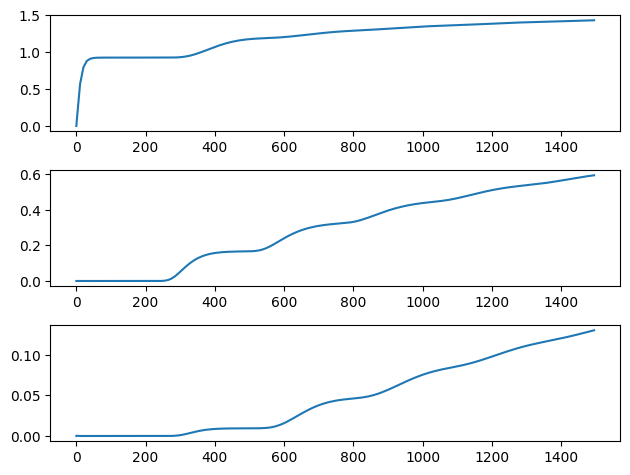

In [9]:

# Set parameters
U0 = 0.2 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

plt.figure()

plt.subplot(3,1,1)
plt.plot(t_save,c_save[:,50,8])

plt.subplot(3,1,2)
plt.plot(t_save, c_save[:,50,16])

plt.subplot(3,1,3)
plt.plot(t_save, c_save[:,50,24])

plt.tight_layout()

plt.show()

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.1e+00/s


2025-11-10 11:08:30,401 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.1e+00/s


INFO:__main__:Starting main loop


2025-11-10 11:08:30,408 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-10 11:08:30,446 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-10 11:08:30,475 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-10 11:08:30,504 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-10 11:08:30,532 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-10 11:08:30,561 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-10 11:08:30,590 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-10 11:08:30,619 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-10 11:08:30,648 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-10 11:08:30,677 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-10 11:08:30,719 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-10 11:08:30,753 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-10 11:08:30,782 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-10 11:08:30,813 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-10 11:08:30,842 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-10 11:08:30,870 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-10 11:08:30,902 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-10 11:08:30,933 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-10 11:08:30,965 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-10 11:08:30,998 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-10 11:08:31,028 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-10 11:08:31,058 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-10 11:08:31,089 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-10 11:08:31,118 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-10 11:08:31,147 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-10 11:08:31,178 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-10 11:08:31,210 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-10 11:08:31,244 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-10 11:08:31,275 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-10 11:08:31,304 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-10 11:08:31,332 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-10 11:08:31,362 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-10 11:08:31,391 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-10 11:08:31,420 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-10 11:08:31,451 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-10 11:08:31,481 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-10 11:08:31,512 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-10 11:08:31,540 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-10 11:08:31,569 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-10 11:08:31,596 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-10 11:08:31,625 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-10 11:08:31,656 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-10 11:08:31,684 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-10 11:08:31,715 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-10 11:08:31,756 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-10 11:08:31,796 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-10 11:08:31,825 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-10 11:08:31,856 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-10 11:08:31,888 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-10 11:08:31,921 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-10 11:08:31,951 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-10 11:08:31,982 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-10 11:08:32,012 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-10 11:08:32,043 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-10 11:08:32,077 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-10 11:08:32,106 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-10 11:08:32,136 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-10 11:08:32,165 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-10 11:08:32,196 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-10 11:08:32,226 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-10 11:08:32,255 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-10 11:08:32,285 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-10 11:08:32,331 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-10 11:08:32,379 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-10 11:08:32,426 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-10 11:08:32,475 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-10 11:08:32,518 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-10 11:08:32,557 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-10 11:08:32,599 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-10 11:08:32,642 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-10 11:08:32,688 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-10 11:08:32,731 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-10 11:08:32,775 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-10 11:08:32,820 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-10 11:08:32,868 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-10 11:08:32,911 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-10 11:08:32,956 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-10 11:08:33,001 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-10 11:08:33,035 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-10 11:08:33,037 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-10 11:08:33,039 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.2318 sec


2025-11-10 11:08:33,041 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2318 sec


INFO:solvers:Warmup time (iter 0-10): 0.06301 sec


2025-11-10 11:08:33,043 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06301 sec


INFO:solvers:Run time (iter 10-end): 2.564 sec


2025-11-10 11:08:33,044 solvers 0/1 INFO :: Run time (iter 10-end): 2.564 sec


INFO:solvers:CPU time (iter 10-end): 0.0007123 cpu-hr


2025-11-10 11:08:33,046 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0007123 cpu-hr


INFO:solvers:Speed: 5.126e+06 mode-stages/cpu-sec


2025-11-10 11:08:33,048 solvers 0/1 INFO :: Speed: 5.126e+06 mode-stages/cpu-sec


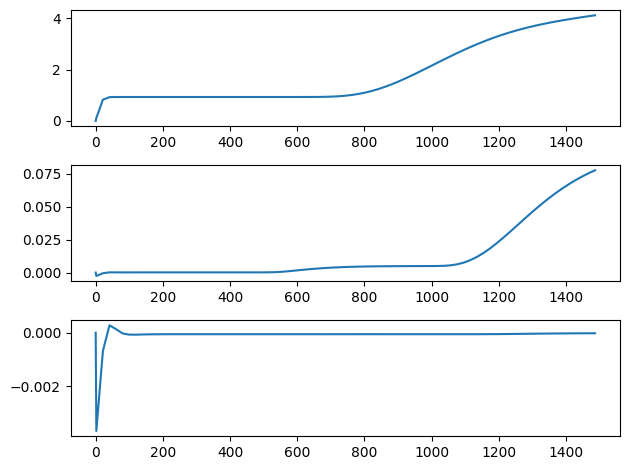

In [10]:
# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-3 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

plt.figure()

plt.subplot(3,1,1)
plt.plot(t_save,c_save[:,50,8])

plt.subplot(3,1,2)
plt.plot(t_save, c_save[:,50,16])

plt.subplot(3,1,3)
plt.plot(t_save, c_save[:,50,24])

plt.tight_layout()

plt.show()

ADD DISCUSSION HERE

from green book
for x direction use fact that advection dominates over diffusion as seen in videa

### Turbulent diffusion
In a turbulent flow, tracers will be transported by the turbulent eddies. A common way to model this is to introduce a turbulent diffusivity, $\kappa_T\sim u*l$, where $u$ and $l$ are characteristic velocity and length scales associated with the turbulent eddies.

To explore this effect, create a Dedalus script that includes advection by $u$ and $v$ (the $x$ and $y$ components of the velocity). Then, use the same velocity field as above for $u$ and add to that a fluctuating velocity field that of the form

$$ u=u_0 cos(kx)cos(ky), \quad v=u_0 sin(kx)sin(ky) $$

where $k$ is the wavenumber associated with the velocity fluctuations and $u_0$ is the amplitude of the fluctuations. Note that $k$ should be set to give an integer number of wavelengths in the $x$ and $y$ directions. Vary both $u_0$ and $k$ and study how quicky the tracer is transported across the river. Qualitatively compare this with the expectation based on the hypothesis of turbulent diffusion.

INSERT PLOTS AND COMMENTS HERE


In [16]:
#solving diffusion equation for fluctuatung velocity field
#change c notation?

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale
k=np.pi*0.2 #NEW gives 1 wavelengths in width 10 choose np.pi for 5 wavelengths (gave negative concentration)

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

#def u(x,y,k):
  #return U0*np.cos(k*x)*np.cos(k*y)
#def v(x,y,k):
  #return U0*np.sin(k*x)*np.sin(k*y)

# Fields CHANGED
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field CHANGED
#u['g'] = u(x,y,k)
#v['g'] = v(x,y,k)
u['g'] = U0*np.cos(k*x)*np.cos(k*y)
v['g'] = U0*np.sin(k*x)*np.sin(k*y)

# Substitutions CHANGED
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem CHANGED
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) + v*dy(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)



INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s


2025-11-10 11:14:47,295 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s


INFO:__main__:Starting main loop


2025-11-10 11:14:47,301 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-10 11:14:47,456 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-10 11:14:47,529 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-10 11:14:47,612 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-10 11:14:47,695 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-10 11:14:47,769 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-10 11:14:47,845 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-10 11:14:47,924 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-10 11:14:47,998 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-10 11:14:48,071 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-10 11:14:48,145 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-10 11:14:48,225 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-10 11:14:48,304 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-10 11:14:48,379 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-10 11:14:48,456 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-10 11:14:48,531 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-10 11:14:48,605 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-10 11:14:48,688 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-10 11:14:48,762 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-10 11:14:48,837 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-10 11:14:48,910 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-10 11:14:48,980 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-10 11:14:49,050 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-10 11:14:49,121 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-10 11:14:49,200 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-10 11:14:49,269 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-10 11:14:49,338 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-10 11:14:49,408 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-10 11:14:49,480 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-10 11:14:49,550 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-10 11:14:49,621 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-10 11:14:49,702 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-10 11:14:49,779 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-10 11:14:49,853 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-10 11:14:49,929 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-10 11:14:50,001 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-10 11:14:50,076 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-10 11:14:50,146 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-10 11:14:50,220 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-10 11:14:50,291 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-10 11:14:50,365 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-10 11:14:50,440 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-10 11:14:50,515 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-10 11:14:50,588 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-10 11:14:50,663 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-10 11:14:50,749 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-10 11:14:50,835 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-10 11:14:50,946 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-10 11:14:51,046 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-10 11:14:51,139 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-10 11:14:51,244 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-10 11:14:51,341 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-10 11:14:51,433 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-10 11:14:51,526 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-10 11:14:51,617 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-10 11:14:51,711 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-10 11:14:51,813 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-10 11:14:51,911 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-10 11:14:52,006 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-10 11:14:52,106 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-10 11:14:52,205 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-10 11:14:52,297 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-10 11:14:52,386 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-10 11:14:52,476 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-10 11:14:52,565 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-10 11:14:52,654 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-10 11:14:52,752 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-10 11:14:52,859 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-10 11:14:52,967 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-10 11:14:53,062 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-10 11:14:53,162 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-10 11:14:53,272 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-10 11:14:53,370 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-10 11:14:53,470 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-10 11:14:53,568 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-10 11:14:53,671 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-10 11:14:53,744 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-10 11:14:53,819 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-10 11:14:53,872 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-10 11:14:53,873 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-10 11:14:53,875 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.591 sec


2025-11-10 11:14:53,876 solvers 0/1 INFO :: Setup time (init - iter 0): 0.591 sec


INFO:solvers:Warmup time (iter 0-10): 0.2173 sec


2025-11-10 11:14:53,877 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.2173 sec


INFO:solvers:Run time (iter 10-end): 6.352 sec


2025-11-10 11:14:53,880 solvers 0/1 INFO :: Run time (iter 10-end): 6.352 sec


INFO:solvers:CPU time (iter 10-end): 0.001764 cpu-hr


2025-11-10 11:14:53,881 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001764 cpu-hr


INFO:solvers:Speed: 2.069e+06 mode-stages/cpu-sec


2025-11-10 11:14:53,882 solvers 0/1 INFO :: Speed: 2.069e+06 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-10 11:15:02,540 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp7ydkmyku/temp.m4v


2025-11-10 11:15:02,542 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp7ydkmyku/temp.m4v


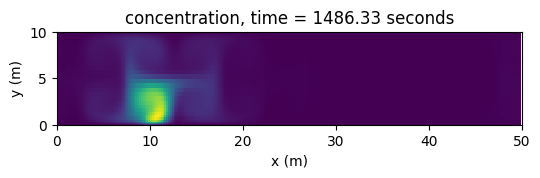

In [17]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)
    plt.ylim(0, w)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

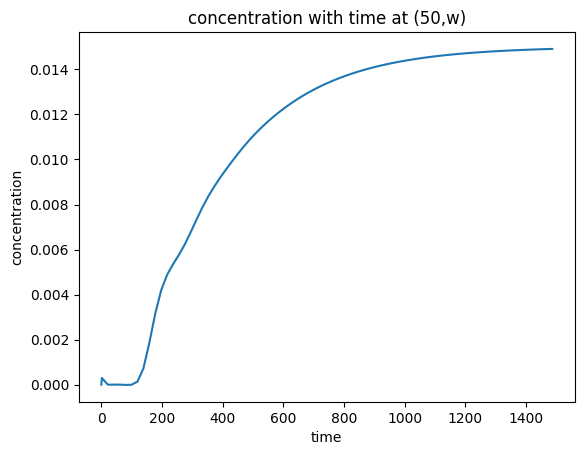

In [18]:
plt.figure()

plt.plot(t_save,c_save[:,50,-1])
plt.title('concentration with time at (50,w)')
plt.xlabel('time')
plt.ylabel('concentration')

plt.show()

In [14]:
#cycle through all time and space systematically at y=w to find first time and first point of non-zero conc
#c_save= [t,x,y] t only up to 78
for t in range (1000):
  for x in range (Nx):
    if c_save[t,x,w] > 0:
      print ('particle found at time = t, distance = x')
    else:
if c_save[t, Nx, w] ==0:
  t=t+1
if c_save[t,x,w] > 0:
  print ('particle found at time = t, distance = x')

#try numpy.nonzero to find index of first nonzero element

IndentationError: expected an indented block after 'else' statement on line 7 (ipython-input-1713766758.py, line 8)

In [1]:
concentration = False
for time in range(len(t_save)):
  for xpos in range(0,Nx):
    if c_save[time, xpos, -1] >0:
      print (f"pollution first crosses river at time = {t_save[time]} s, distance = {x[xpos,0]}m")
      concentration = True
      break
  if concentration == True:
    break

NameError: name 't_save' is not defined

In [ ]:
# U=0.1, k=pi/10

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale
k=np.pi*0.1 #NEW gives 1/2 wavelengths in width 10 choose np.pi for 5 wavelengths (gave negative concentration)

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

#def u(x,y,k):
  #return U0*np.cos(k*x)*np.cos(k*y)
#def v(x,y,k):
  #return U0*np.sin(k*x)*np.sin(k*y)

# Fields CHANGED
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field CHANGED
#u['g'] = u(x,y,k)
#v['g'] = v(x,y,k)
u['g'] = U0*np.cos(k*x)*np.cos(k*y)
v['g'] = U0*np.sin(k*x)*np.sin(k*y)

# Substitutions CHANGED
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem CHANGED
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) + v*dy(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)


fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)
    plt.ylim(0, w)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 49s, Remaining: 0s, Rate: 2.1e-02/s


2025-11-10 11:23:34,175 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 49s, Remaining: 0s, Rate: 2.1e-02/s


INFO:__main__:Starting main loop


2025-11-10 11:23:34,183 __main__ 0/1 INFO :: Starting main loop


## 3. Optional further investigations

* In the river pollution example, you might notice that the concentration field is mixed more effectively in the x-direction than in the y-direction. The combination of differential advection by the currents and cross-stream diffusion is very effective at mixing the plume in the x-direction. This is an example of Taylor dispersion (Taylor, 1953). Construct numerical experiments to quantify Taylor dispersion and its dependence on the current shear and the diffusivity. You could also separate the diffusivity into parts in the x and y directions with different coefficients.  If you set the x-component of the diffusivity to zero, then any spreading of the concentration in the x-direction should be due to Taylor dispersion.

* Try making the river speed a function of time. The easiest way to do this is to add a new equation so that Dedalus solves for the velocity in addition to the concentration field. For example, you could make the river speed decrease exponentially in time, or it could be sinusoidal in time.

* In the ocean mixing example, if $\kappa$ is a function of $x$ and $z$, what would this imply about the velocity field? You could even try writing a Dedalus script to solve the 2D advection/diffusion equation with a prescribed spatially-dependent $\kappa(x,z)$.


### References

Munk, W.H., 1966. Abyssal recipes. In Deep sea research and oceanographic abstracts (Vol. 13, No. 4, pp. 707-730). Elsevier.

Ferrari, R., Mashayek, A., McDougall, T.J., Nikurashin, M. and Campin, J.M., 2016. Turning ocean mixing upside down. Journal of Physical Oceanography, 46(7), pp.2239-2261.

Taylor, G.I., 1953. Dispersion of soluble matter in solvent flowing slowly through a tube. Proceedings of the Royal Society of London. Series A. Mathematical and Physical Sciences, 219(1137), pp.186-203.